# Attempt at polarization reco

### Sep 17, 2020

## Code

In [1]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util

Welcome to JupyROOT 6.18/04


In [2]:
# mpl.use('agg') 
# mpl.rcParams['text.usetex'] = True
# mpl.rcParams['text.latex.unicode'] = True
# mpl.rcParams['mathtext.rm'] = 'Times New Roman'
# mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
# mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

# mpl.rc('font', family='serif', size=12)
# mpl.rcParams['xtick.labelsize'] = 14
# mpl.rcParams['ytick.labelsize'] = 14
# mpl.rcParams['xtick.major.size'] = 5
# mpl.rcParams['ytick.major.size'] = 5

# mpl.rcParams['axes.titlesize'] = 18
# mpl.rcParams['axes.labelsize'] = 18
# # mpl.rc('font', size=16)
# mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


## Define function

In [184]:
def random_three_vector():
    """
    Generates a random 3D unit vector (direction) with a uniform spherical distribution
    Algo from http://stackoverflow.com/questions/5408276/python-uniform-spherical-distribution
    :return:
    """
    np.random.seed(9)
    phi = np.random.uniform(0,np.pi)
    costheta = np.random.uniform(0,1)

    theta = np.arccos( costheta )
    x = np.sin( theta) * np.cos( phi )
    y = np.sin( theta) * np.sin( phi )
    z = np.cos( theta )
    return np.array([x,y,z])

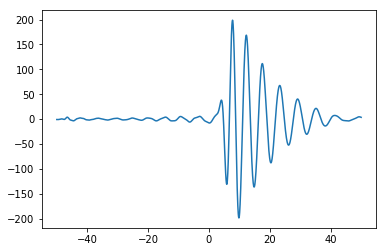

In [169]:
# phi = np.deg2rad(90)
# theta = np.deg2rad(90)
from scipy import signal
pol_ev = np.array([0.,0,1])
dirProp = np.array([1,0,0])
# dirProp = random_three_vector()
pol_ev
phi = np.arctan2(dirProp[1],dirProp[0])
theta = np.arccos(dirProp[2])
wform = pd.read_pickle("./wform_forDebug_PyREx.pkl")

sig = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds
antV = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
sig = antV.apply_response(sig, direction=dirProp, polarization=pol_ev, force_real=True)
output = antV.front_end(sig)

timeV = output.times*1E9 #in ns
voltageV = output.values*1E3 #in mV
plt.plot(timeV,voltageV)

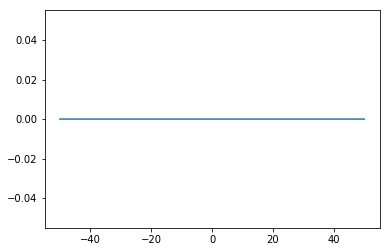

In [170]:
sigH = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds

antH = util.ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, 0), power_threshold=0)
sigH = antH.apply_response(sigH, direction=dirProp, polarization=pol_ev, force_real=True)
outputH = antH.front_end(sigH)
timeH = outputH.times*1E9 #in ns
voltageH = outputH.values*1E3 #in mV

plt.plot(timeH,voltageH)

Text(0,0.5,'Voltage [mV]')

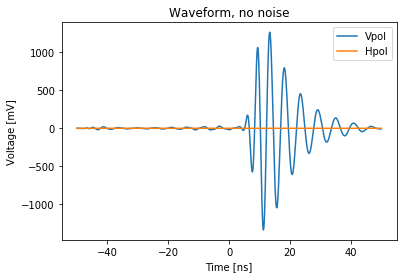

In [171]:
deConv_V_t,deConv_V_v = util.deConvolve_antenna(timeV, voltageV, theta, phi, 0)
deConv_H_t,deConv_H_v = util.deConvolve_antenna(timeH, voltageH, theta, phi, 1)

plt.plot(deConv_V_t,deConv_V_v, label = "Vpol")
plt.plot(deConv_H_t,deConv_H_v, label = "Hpol")
plt.legend()
plt.title("Waveform, no noise")
plt.xlabel("Time [ns]")
plt.ylabel("Voltage [mV]")

### Calculate polarization angle from Stokes parameters

In [172]:
def PolAngleStokes(Hpol,Vpol):
    return np.degrees(0.5*np.arctan2(2*Hpol*Vpol,(Hpol**2-Vpol**2)))

In [174]:
PolAngleStokes(max(abs(deConv_H_v)),max(abs(deConv_V_v)))

90.0

In [178]:
np.arccos(pol_ev[2])

0.0

In [8]:
def PolRatio(Hpol,Vpol):
    return np.degrees(np.arctan(Hpol/Vpol))

In [30]:
def findMaxAmp(voltage):
    if(abs(max(voltage))>=abs(min(voltage))):
        maxAmp = max(voltage)
    else:
        maxAmp = min(voltage)
    return maxAmp

# Generate random polarizations

dir_prop:[0.86448107 0.0281846  0.50187459]
pol_vec:[-0.50234495  0.08408444  0.8605692 ]
theta_reco:85.069
theta_true:30.619
30.61944679773912


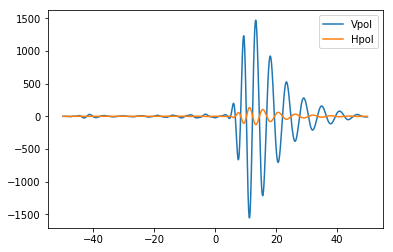

In [190]:
reco=[]
true=[]
antV = util.ara.VpolAntenna(name="Dummy Vpol", position=(0, 0, 0), power_threshold=0)
antH = util.ara.HpolAntenna(name="Dummy Hpol", position=(0, 0, 0), power_threshold=0)

wform = pd.read_pickle("./wform_forDebug_PyREx.pkl")
for count in range(0,1000):
#     dirProp = np.array([1/np.sqrt(2),0,1/np.sqrt(2)])
    dirProp =  random_three_vector()
    pol_ev = np.random.randn(3)  # take a random vector
    pol_ev -= pol_ev.dot(dirProp) * dirProp       # make it orthogonal to k
    pol_ev /= np.linalg.norm(pol_ev) 

    phi = np.arctan2(dirProp[1],dirProp[0])
    theta = np.arccos(dirProp[2])
#     pol_ev = random_three_vector()
    
    sig = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds
    sig = antV.apply_response(sig, direction=dirProp, polarization=pol_ev, force_real=True)
    output = antV.front_end(sig)

    timeV = output.times*1E9 #in ns
    voltageV = output.values*1E3 #in mV

    sigH = pyrex.Signal(wform["time"]*1E-9,wform.voltage*1E-3,'voltage') # times in seconds

    sigH = antH.apply_response(sigH, direction=dirProp, polarization=pol_ev, force_real=True)
    outputH = antH.front_end(sigH)
    timeH = outputH.times*1E9 #in ns
    voltageH = outputH.values*1E3 #in mV

    deConv_V_t,deConv_V_v = util.deConvolve_antenna(timeV, voltageV, theta, phi, 0)
    deConv_H_t,deConv_H_v = util.deConvolve_antenna(timeH, voltageH, theta, phi, 1)
    reco_ = PolAngleStokes(max(abs(deConv_H_v)),max(abs(deConv_V_v)))
    true_ = np.degrees(np.arccos(pol_ev[2]))
    if(reco_-true_>50):
#         continue
#         true_=abs(90-true_)
#     if(reco_-true_)>70:
        print("dir_prop:%s"%dirProp)
        print("pol_vec:%s"%pol_ev)
        print("theta_reco:%0.3f"%reco_)
        print("theta_true:%0.3f"%true_)
        print(np.degrees(np.arccos(pol_ev[2])))
        plt.plot(deConv_V_t,deConv_V_v,label="Vpol")
        plt.plot(deConv_H_t,deConv_H_v, label="Hpol")
        plt.legend()
        break
#     reco.append(reco_)
#     true.append(true_)
#     print((PolAngleStokes(max(abs(deConv_H_v)),max(abs(deConv_V_v)))-np.degrees(theta)))

In [159]:
reco=np.array(reco)
true=np.array(true)
dist = pd.DataFrame({"reco":reco, "true":true})
dist.head()
gt90 = dist.loc[dist.true>90]
lt90 = dist.loc[dist.true<=90]

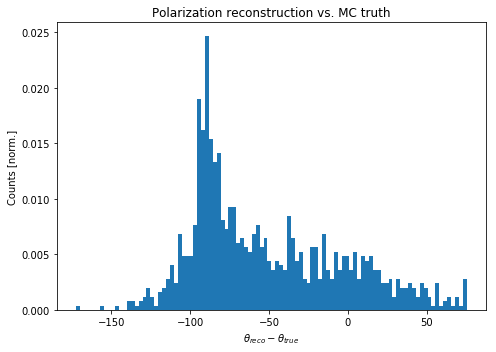

In [160]:
plt.figure(figsize=(7,5))
plt.hist(reco-true, bins=100, density=True);
plt.xlabel("$\\theta_{reco}-\\theta_{true}$")
plt.ylabel('Counts [norm.]')
plt.title("Polarization reconstruction vs. MC truth")
# plt.yscale("log")
plt.tight_layout()
# plt.savefig("./plots/Stokes/recoVsTrue_MC.png", dpi=200)

Text(0,0.5,'$\\theta_{reco}$')

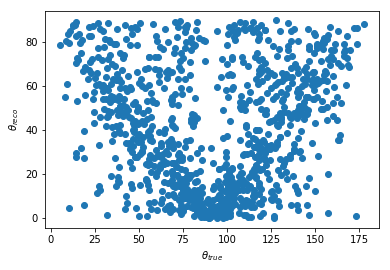

In [162]:
plt.scatter(true,reco)
plt.xlabel("$\\theta_{true}$")
plt.ylabel('$\\theta_{reco}$')

<function matplotlib.pyplot.savefig(*args, **kwargs)>

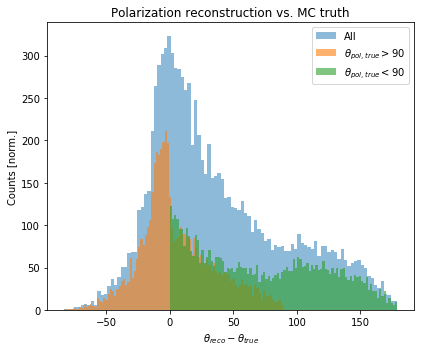

In [72]:
plt.figure(figsize=(6,5))
plt.hist(reco-true+90, bins=100, density=False,alpha=0.5, label="All");

plt.hist(gt90.reco-gt90.true+90,normed=False, bins=100,alpha=0.6, label = "$\\theta_{pol, true}>90$");
plt.hist(lt90.reco-lt90.true+90, bins=100,normed=False, alpha=0.6, label = "$\\theta_{pol, true}<90$");
plt.xlabel("$\\theta_{reco}-\\theta_{true}$")
plt.ylabel('Counts [norm.]')
plt.title("Polarization reconstruction vs. MC truth")
# plt.yscale("log")
plt.legend()
plt.tight_layout()
plt.savefig
# plt.savefig("./plots/Stokes/Dist_split.png", dpi=200)

In [73]:
movedDist = gt90.copy()
# movedDist.loc[movedDist['true'] >90 , 'true'] = 180-movedDist['true']
# movedDist['true'] = movedDist['true']+90
movedDist.reco-movedDist.true

0       -90.399348
2      -146.350086
3      -103.459558
6       -97.857606
8       -50.348372
           ...    
9991    -56.378932
9992    -87.385694
9994   -101.867587
9997   -131.251436
9998    -60.860751
Length: 5025, dtype: float64

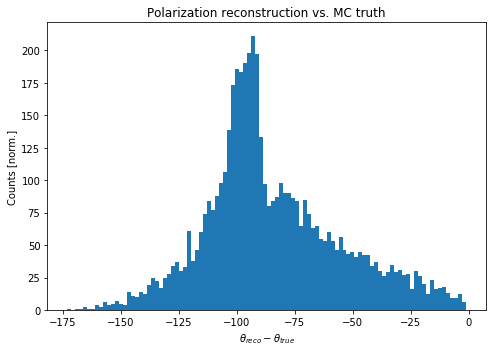

In [74]:
plt.figure(figsize=(7,5))
plt.hist(movedDist.reco-movedDist.true, bins=100, density=False);
plt.xlabel("$\\theta_{reco}-\\theta_{true}$")
plt.ylabel('Counts [norm.]')
plt.title("Polarization reconstruction vs. MC truth")
# plt.yscale("log")
plt.tight_layout()

In [75]:
(reco-true).std()

52.4898512577496

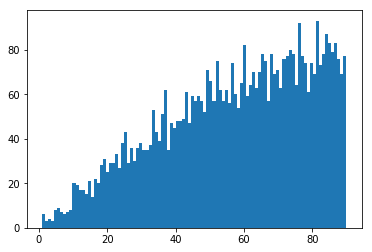

In [76]:
plt.hist(lt90.true, bins=100);
# plt.hist(reco, bins=100, alpha=.5);

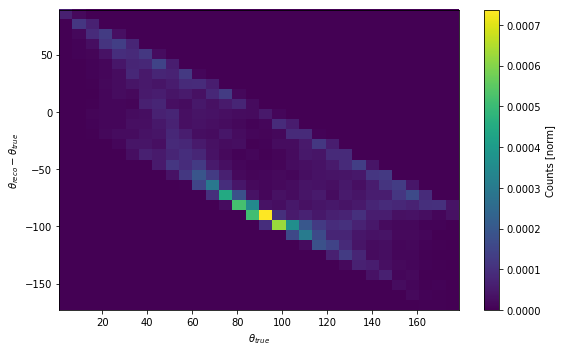

In [77]:
plt.figure(figsize=(8,5))
plt.hist2d(true,reco-true, bins=30, normed=True);
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.colorbar(label="Counts [norm]")
plt.xlabel("$\\theta_{true}$")
plt.ylabel("$\\theta_{reco}-\\theta_{true}$")
plt.tight_layout()
# plt.savefig("./plots/Stokes/recovsRecoMinusTrue_MC.png", dpi=200)

In [29]:
np.std(reco-true+180)

48.31943184913065

In [40]:
Stokes_reco = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/pol_quant.pkl")
Stokes_reco["delta"] = 90+Stokes_reco.AngStokes-np.degrees(np.arccos(Stokes_reco.pol_z))
Stokes_reco["pol_z_angle"] = 180-np.degrees(np.arccos(Stokes_reco.pol_z))
Stokes_reco.head()


,EvNum,theta_reco,theta_antenna,pol_x,pol_y,pol_z,AngStokes,AngRatio,delta,pol_z_angle
0,41,62.0,63.874833,-0.468684,0.457021,0.755955,27.838725,62.161275,76.947572,139.108847
1,70,83.0,86.413732,0.197785,0.512993,-0.835296,35.095173,54.904827,-21.551476,33.353350
2,143,71.0,72.764205,-0.153866,-0.426478,0.891315,41.621173,48.378827,104.660099,153.038926
3,331,97.0,82.471256,-0.605470,0.358202,-0.710702,20.651759,69.348241,-24.640303,44.707938
4,336,82.0,85.621076,-0.313883,0.577852,-0.753369,32.106986,57.893014,-16.776049,41.116966


In [41]:
Stokes_reco.loc[Stokes_reco['pol_z_angle'] >90 , 'pol_z_angle'] = 180-Stokes_reco.pol_z_angle
Stokes_reco.head()

,EvNum,theta_reco,theta_antenna,pol_x,pol_y,pol_z,AngStokes,AngRatio,delta,pol_z_angle
0,41,62.0,63.874833,-0.468684,0.457021,0.755955,27.838725,62.161275,76.947572,40.891153
1,70,83.0,86.413732,0.197785,0.512993,-0.835296,35.095173,54.904827,-21.551476,33.353350
2,143,71.0,72.764205,-0.153866,-0.426478,0.891315,41.621173,48.378827,104.660099,26.961074
3,331,97.0,82.471256,-0.605470,0.358202,-0.710702,20.651759,69.348241,-24.640303,44.707938
4,336,82.0,85.621076,-0.313883,0.577852,-0.753369,32.106986,57.893014,-16.776049,41.116966


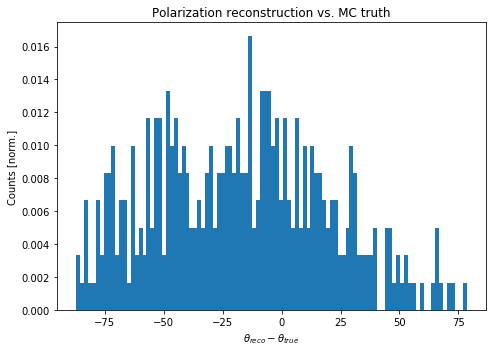

In [42]:
plt.figure(figsize=(7,5))
plt.hist(Stokes_reco.AngStokes-Stokes_reco.pol_z_angle,bins=100, normed=True);
plt.xlabel("$\\theta_{reco}-\\theta_{true}$")
plt.ylabel('Counts [norm.]')
plt.title("Polarization reconstruction vs. MC truth")
plt.tight_layout()
# plt.savefig("./plots/Stokes/recovsTrue.pdf")

Text(0,0.5,'$\\theta_{reco}-\\theta_{true}$')

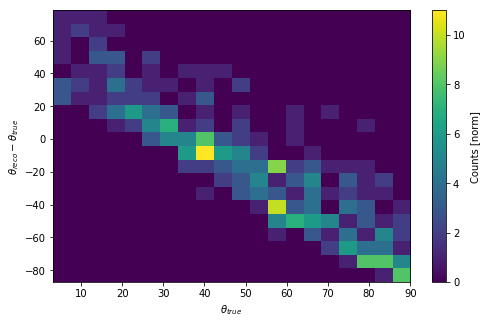

In [43]:
plt.figure(figsize=(8,5))
plt.hist2d(Stokes_reco.pol_z_angle,Stokes_reco.AngStokes-Stokes_reco.pol_z_angle, bins=20, normed=False);
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.colorbar(label="Counts [norm]")
plt.xlabel("$\\theta_{true}$")
plt.ylabel("$\\theta_{reco}-\\theta_{true}$")
# plt.savefig("./plots/Stokes/recovsRecoMinusTrue.pdf")

In [ ]:
Stokes_reco.loc[Stokes_reco.EvNum==143]

In [ ]:
debug = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/pol_quant_debug.pkl")

In [ ]:
np.degrees(np.arccos(debug.pol_z))

In [ ]:
41.621173+90

In [ ]:
fig = plt.figure(figsize=(8,6))
left, bottom, width, height = 0.1, 0.1, 0.8, 0.8
ax = fig.add_axes([left, bottom, width, height]) 

start, stop, n_values = 0, 1, 1000

x_vals = np.linspace(start, stop, n_values)
y_vals = 1-x_vals#np.linspace(start, stop, n_values)
X, Y = np.meshgrid(x_vals, y_vals)


Z = np.degrees(0.5*np.arctan2(2*X*Y,(X**2-Y**2)))

cp = plt.contourf(X, Y, Z,90)
# plt.clabel(cp)
plt.colorbar(cp, label="Polarization angle of incoming signal [deg]")

ax.set_title('Polarization angle from Stokes parameters')
ax.set_xlabel('$E_{hpol}$ [normalized]')
ax.set_ylabel('$E_{vpol}$ [normalized]')
# plt.show()
plt.tight_layout()
plt.savefig("./plots/Stokes/Stokes.pdf")